# Natural Language Processing with Disaster Tweets



## Setup

In [57]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import plot_model



In [6]:

# id     keyword    location    text    target
training_csv_data = pd.read_csv('./data/train.csv')
testing_csv_data = pd.read_csv('./data/test.csv')

print(training_csv_data.head())
training_csv_data.describe()

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


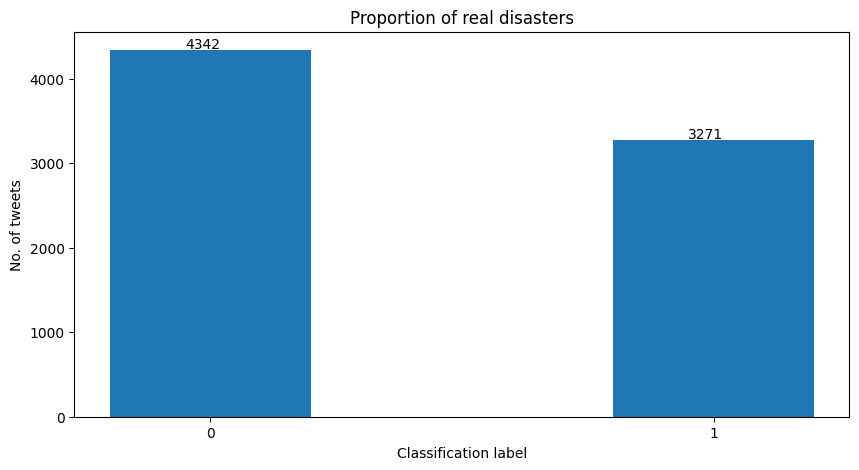

In [42]:
# creating the dataset

data = training_csv_data["target"].value_counts()
topics = list(data.axes[0])
topics = [str(item) for item in topics]
values = list(data.values)

fig = plt.figure(figsize=(10, 5))
plt.bar(topics, values, width=0.4)

for i in range(len(values)):
        plt.text(i - 0.05, values[i] + 20, values[i])

plt.xlabel("Classification label")
plt.ylabel("No. of tweets")
plt.title("Proportion of real disasters")
plt.show()

In [14]:
training_directory = "./data/train/"

# For all files in training directory
for ind in training_csv_data.index:
    # Create filename using label and ID
    filename = training_directory + str(training_csv_data["target"][ind]) + "/" + str(training_csv_data["id"][ind]) + ".txt"
    
    # Export the sample's text
    text_file = open(filename, "w", encoding="utf-8")
    text_file.write(training_csv_data["text"][ind])
    text_file.close()

In [16]:
testing_directory = "./data/test/"

# For all files in testing directory
for ind in testing_csv_data.index:
    # Create filename using ID
    filename = testing_directory + str(testing_csv_data["id"][ind]) + ".txt"
    
    # Export the sample's text
    text_file = open(filename, "w", encoding="utf-8")
    text_file.write(testing_csv_data["text"][ind])
    text_file.close()

In [17]:
training_dataset, validation_dataset = tf.keras.utils.text_dataset_from_directory(
    "./data/train/",
    label_mode="binary",
    validation_split=0.15,
    shuffle=True,
    batch_size=None,
    subset="both",
    seed=1337,
)

Found 7613 files belonging to 2 classes.
Using 6472 files for training.
Using 1141 files for validation.


In [18]:
testing_dataset = tf.keras.utils.text_dataset_from_directory(
    "./data/test/",
    labels=None,
    label_mode=None,
    batch_size=None,
    shuffle=False
)

Found 3263 files belonging to 1 classes.


In [19]:
for root, dirs, files in os.walk("./data/test/", topdown=False):
    testing_ids = [name[:len(name)-4] for name in files]
print(len(testing_ids))

3263


In [20]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

training_dataset_ = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset_ = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testing_dataset_ = testing_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
encoder = layers.TextVectorization(max_tokens=1000)
encoder.adapt(training_dataset_.map(lambda text, label: text))

In [58]:
# Define model's architecture
model = tf.keras.Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(1)),
    layers.Dense(1, activation="sigmoid")
])


model.summary()
print("Number of trainable parameters: ", model.count_params())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_13 (Embedding)    (None, None, 300)         300000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 2)                 2416      
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
Total params: 302419 (1.15 MB)
Trainable params: 302419 (1.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Number of trainab

In [43]:
import tensorflow as tf
from tensorflow import keras

# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ],
)

# Train model
history = model.fit(
    training_dataset_,
    epochs=20,
    validation_data=validation_dataset_,
    callbacks=[early_stopping_cb]
)


Epoch 1/20


203/203 [==============================] - 7s 18ms/step - loss: 0.6784 - binary_accuracy: 0.6184 - precision: 0.8732 - recall: 0.1290 - val_loss: 0.6592 - val_binary_accuracy: 0.6801 - val_precision: 0.9392 - val_recall: 0.2808
Epoch 2/20
203/203 [==============================] - 3s 13ms/step - loss: 0.6090 - binary_accuracy: 0.7787 - precision: 0.8237 - recall: 0.6160 - val_loss: 0.5828 - val_binary_accuracy: 0.7686 - val_precision: 0.8272 - val_recall: 0.5899
Epoch 3/20
203/203 [==============================] - 3s 14ms/step - loss: 0.5479 - binary_accuracy: 0.8079 - precision: 0.8486 - recall: 0.6722 - val_loss: 0.5589 - val_binary_accuracy: 0.7704 - val_precision: 0.7618 - val_recall: 0.6848
Epoch 4/20
203/203 [==============================] - 3s 14ms/step - loss: 0.5192 - binary_accuracy: 0.8200 - precision: 0.8534 - recall: 0.7006 - val_loss: 0.5416 - val_binary_accuracy: 0.7800 - val_precision: 0.7976 - val_recall: 0.6606
Epoch 5/20
203/203 [==============================] - 3

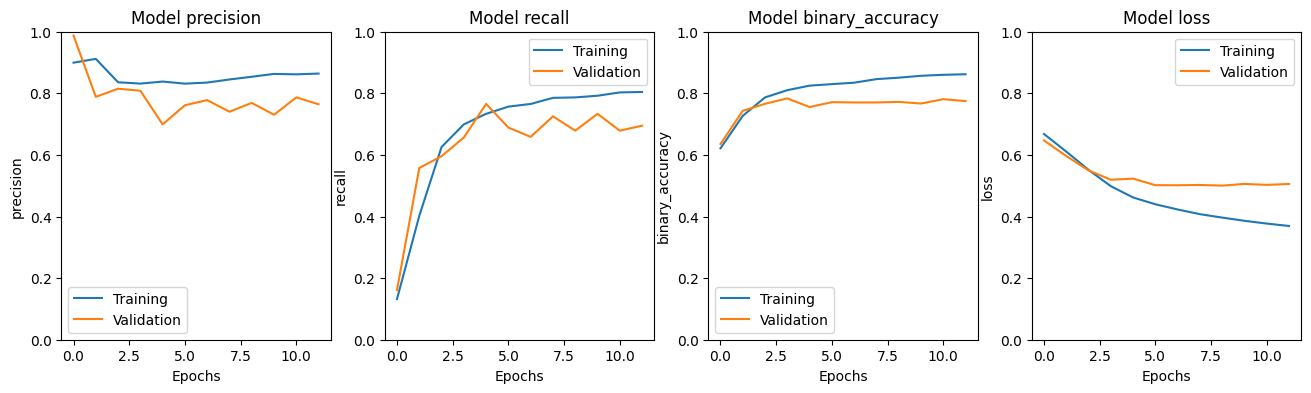

In [25]:
# graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# Get the available metrics from history.history
graph_metrics = list(history.history.keys())

# Create the figure and subplots
fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
fig.suptitle("Model Evaluation Metrics", fontsize=16)

# Iterate over the metrics and plot them
for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])

    ax[i].set_title(metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)

plt.tight_layout()
plt.show()


102/102 [==============================] - 2s 6ms/step
[[<Axes: title={'center': 'target'}>]]


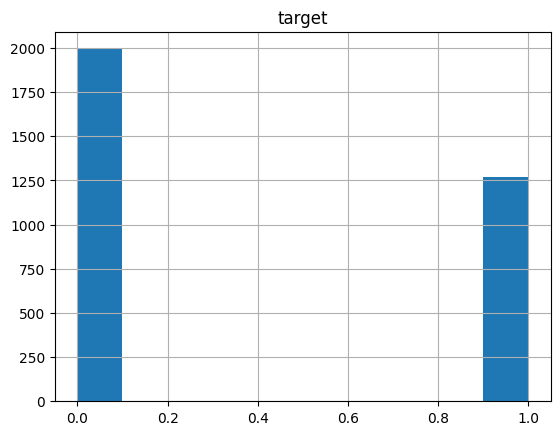

In [44]:
# Obtain predicted labels for testing dataset. Round predictions to obtain 0/1 values.
testing_predictions = model.predict(testing_dataset_)
testing_prediction_labels = [round(item[0]) for item in testing_predictions.tolist()]

# Merge testing IDs and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "target": testing_prediction_labels})
testing_results = testing_results.sort_values(by=['id'], ascending=True)

# Export predictions to a CSV file
testing_results.to_csv("./data/results1.csv", index=False)
testing_results.head()
print(testing_results.hist())

In [ ]:

model = tf.keras.Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dense(30, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])


model.summary()

Epoch 1/20


203/203 [==============================] - 7s 18ms/step - loss: 0.3813 - binary_accuracy: 0.8764 - precision: 0.9013 - recall: 0.7994 - val_loss: 0.5181 - val_binary_accuracy: 0.7774 - val_precision: 0.7876 - val_recall: 0.6667
Epoch 2/20
203/203 [==============================] - 3s 13ms/step - loss: 0.3749 - binary_accuracy: 0.8795 - precision: 0.9008 - recall: 0.8080 - val_loss: 0.5189 - val_binary_accuracy: 0.7739 - val_precision: 0.7724 - val_recall: 0.6788
Epoch 3/20
203/203 [==============================] - 3s 13ms/step - loss: 0.3718 - binary_accuracy: 0.8793 - precision: 0.9024 - recall: 0.8058 - val_loss: 0.5225 - val_binary_accuracy: 0.7748 - val_precision: 0.7807 - val_recall: 0.6687
Epoch 4/20
203/203 [==============================] - 3s 13ms/step - loss: 0.3748 - binary_accuracy: 0.8759 - precision: 0.8938 - recall: 0.8066 - val_loss: 0.5209 - val_binary_accuracy: 0.7756 - val_precision: 0.7735 - val_recall: 0.6828


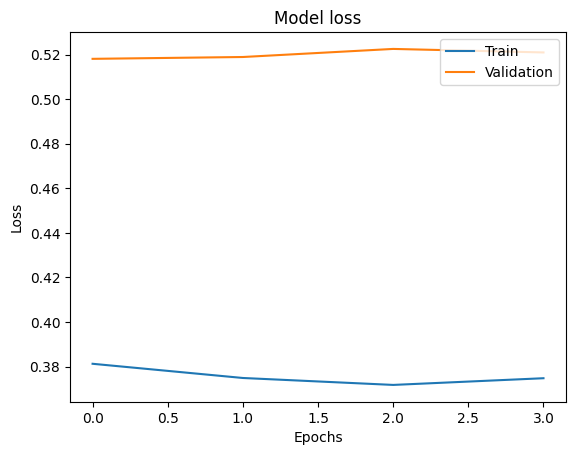

In [46]:

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

history = model.fit(
    training_dataset_,
    epochs=20,
    validation_data=validation_dataset_,
    callbacks=[early_stopping_cb]
) 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


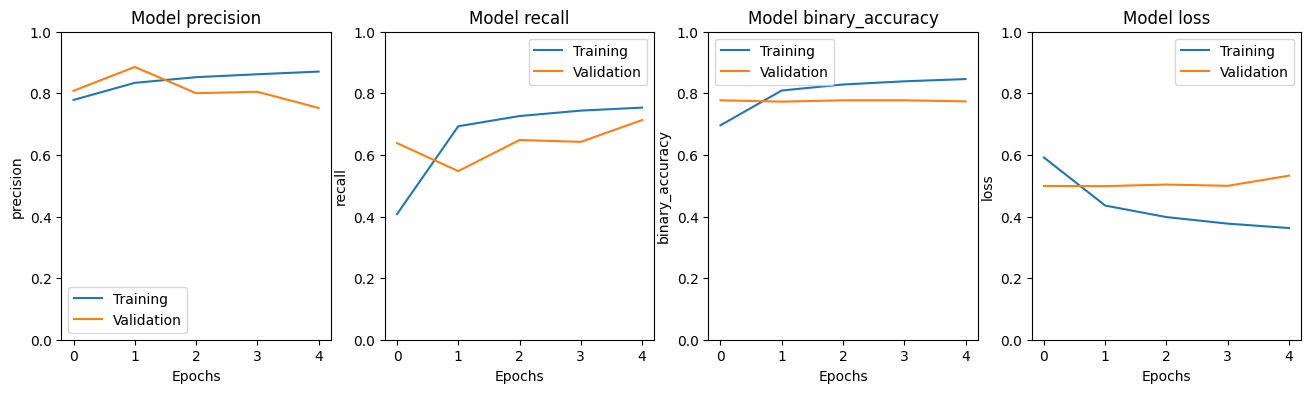

In [30]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


In [ ]:
testing_predictions = model.predict(testing_dataset_)
testing_prediction_labels = [round(item[0]) for item in testing_predictions.tolist()]

testing_results = pd.DataFrame({"id": testing_ids, "target": testing_prediction_labels})
testing_results = testing_results.sort_values(by=['id'], ascending=True)

testing_results.to_csv("./data/results2.csv", index=False)
testing_results.head()

real_disaster = training_csv_data[training_csv_data["target"] == 1]
print("Percentage of real disasters: {}%".format(len(real_disaster)/len(training_csv_data)*100))


In [64]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

model = tf.keras.Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.LSTM(1),
    layers.Dense(1, activation="sigmoid")
])


model.summary()
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True, show_layer_names=True)



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_19 (Embedding)    (None, None, 300)         300000    
                                                                 
 lstm_19 (LSTM)              (None, 1)                 1208      
                                                                 
 dense_20 (Dense)            (None, 1)                 2         
                                                                 
Total params: 301210 (1.15 MB)
Trainable params: 301210 (1.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions

In [68]:
# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    # optimizer=keras.optimizers.SGD(learning_rate=0.00125),
    loss="binary_crossentropy",
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

# Train model
history = model.fit(
    training_dataset_,
    epochs=20,
    validation_data=validation_dataset_,
    callbacks=[early_stopping_cb]
) 


Epoch 1/20


203/203 [==============================] - 7s 18ms/step - loss: 0.6768 - binary_accuracy: 0.5896 - precision: 0.7419 - recall: 0.0663 - val_loss: 0.6601 - val_binary_accuracy: 0.6004 - val_precision: 0.8679 - val_recall: 0.0929
Epoch 2/20
203/203 [==============================] - 3s 14ms/step - loss: 0.6179 - binary_accuracy: 0.7033 - precision: 0.8323 - recall: 0.3862 - val_loss: 0.5949 - val_binary_accuracy: 0.7257 - val_precision: 0.8160 - val_recall: 0.4747
Epoch 3/20
203/203 [==============================] - 3s 13ms/step - loss: 0.5427 - binary_accuracy: 0.7693 - precision: 0.7980 - recall: 0.6189 - val_loss: 0.5489 - val_binary_accuracy: 0.7441 - val_precision: 0.7781 - val_recall: 0.5737
Epoch 4/20
203/203 [==============================] - 3s 14ms/step - loss: 0.4952 - binary_accuracy: 0.7896 - precision: 0.8021 - recall: 0.6762 - val_loss: 0.5230 - val_binary_accuracy: 0.7564 - val_precision: 0.7577 - val_recall: 0.6444
Epoch 5/20
203/203 [==============================] - 3

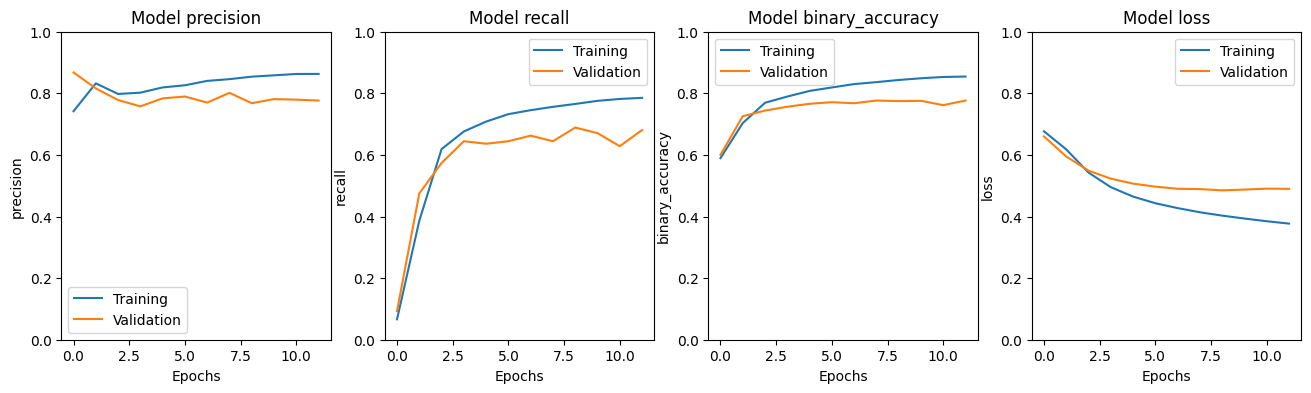

In [69]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# graph_metrics = ["binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


Once again the result is very similar to the previous models, with only a minute dicrease in trainable parameters.

In [41]:
# Obtain predicted labels for testing dataset. Round predictions to obtain 0/1 values.
testing_predictions = model.predict(testing_dataset_)
testing_prediction_labels = [round(item[0]) for item in testing_predictions.tolist()]

# Merge testing IDs and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "target": testing_prediction_labels})
testing_results = testing_results.sort_values(by=['id'], ascending=True)

# Export predictions to a CSV file
testing_results.to_csv("./Data/results3.csv", index=False)
testing_results.head()
#percentage of real disasters
real_disasters = training_csv_data[training_csv_data["target"] == 1]
print("Percentage of real disasters: {}%".format(len(real_disasters)/len(training_csv_data)*100))


  1/102 [..............................] - ETA: 2s

102/102 [==============================] - 1s 6ms/step
Percentage of real disasters: 42.96597924602653%
